In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
tf.enable_eager_execution()

/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/n/home10/mburhanpurkar/.conda/env

In [6]:
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    if test:
        w2_star = np.ones(r)
        W1_star = np.array([1, 0]).reshape(r, d)#np.ones((r, d))
    else:
        w2_star = np.random.rand(r)
        W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid everything being mean 0
    if no_noise:
        y = (M @ inputs).reshape(1, n)
    else:
        y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star


def split_sets(w2, W1, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = W1
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    def predict(xs, j):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out[:, j]
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = predict(sets[i][0], j)
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]
            # print(features)
            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert k != B - 1, 'features[sample_id]=' + str(features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_set(sample, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    features = W1 @ sample

    for i in range(len(set_ranges)):
        flag = True
        for j in range(len(features)):
            if not(features[j] >= set_ranges[i][j][0] and features[j] <= set_ranges[i][j][1]):
                flag = False
                break
        if flag:
            return i
    print("The given element", sample, "could not be contained within set_ranges")
    raise ValueError


def get_sets(samples, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    def predict(xs):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out
    
    features = predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, w1, W2, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, w1, W2, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(sample, r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_num = get_set(sample, r, w2, W1, quantiles_list, set_ranges)
    weights = D2_weights[set_num]
    counts = D2_counts[set_num]
    return weights / counts


def predict(xs, w2, W1, only_top=True):
    n = len(xs)
    if only_top:
        out = np.empty((n, len(xs[0])))
        for i in range(n):
            out[i] = W1 @ xs[i]
        return out
    out = np.empty(n)
    for i in range(n):
        out[i] = w2 @ W1 @ xs[i]
    return out


def get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, 
              x_valid, y_valid, n_train, n_valid, D2, plot=True):
    """Define the linear model and optimize
       d: number of dimensions of the input
       r: number of dimensions in the "second to last layer"
       eps: error added to true function in data
       lr: learning rate for gradient descent
       reg: choice of lambda for L2 regularization
       n_epochs: number of epochs to train for
    """
    mses = []

    assert(r == 1)
    w2 = np.random.rand(r)
    W1 = np.random.rand(r, d)
        
    for epoch in range(n_epochs):        
        mse = 0
        vals = []
        for i in range(n_valid):
            vals.append(w2 @ W1 @ x_valid[i])
            mse += (vals[-1] - y_valid[i])**2
        mse /= n_valid

        # At every epoch, run Linjun's method
        sets, set_counts, set_ranges, quantiles_list = split_sets(w2, W1, (x_train, y_train), C, B, r)
        if (epoch < 5 or epoch == 20) and plot:
            %matplotlib inline 
            fig = plt.figure()
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()
        
        D2_counts, D2_weights = compute_D2(D2, r, w2, W1, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Check the accuracy
        fhat_test = np.empty(n_test)
        for i in range(n_test):
            fhat_test[i] = fhat(x_test[i], r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges)
        if (epoch < 5 or epoch == 20) and plot:
            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            
            plt.plot(x_valid[:, 0], x_valid[:, 1], y_valid, 'o', label='f', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], vals, 'o', label='f*', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], [vals[i] / w2[0] for i in range(len(vals))], 'o', label='h*')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()
    
        mse_nn = np.square(predict(x_test, w2, W1, only_top=False) - y_test).mean()
        mse_fhat = np.square(np.subtract(fhat_test, y_test)).mean()
        print("FHT MSE:", mse_fhat)
        mses.append(mse_fhat)
        
        if epoch > 20 and epoch % 10 == 0:
            lr /= 2
        grads = np.zeros(r + d)
        for i in range(n_train):
            xi = x_train[i]
            yi = y_train[i]
            tmp = 2 * (w2 @ W1 @ xi - yi)
            grads[:r] += tmp * W1 @ xi 
            grads[r:] += tmp * w2 * xi
        w2 = w2 - lr * (grads[:r]) - reg * np.abs(w2)
        W1 = W1 - lr * (grads[r:]) - reg * np.abs(W1)
        
    return w2, W1, mses

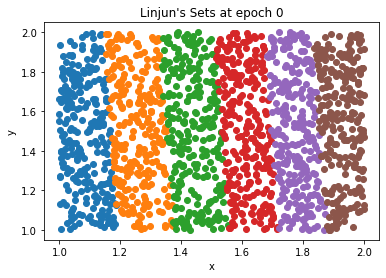

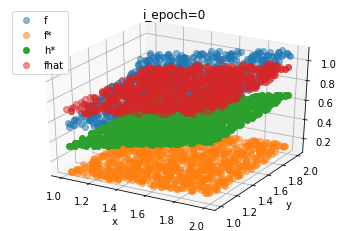

FHT MSE: 0.006723426325411095


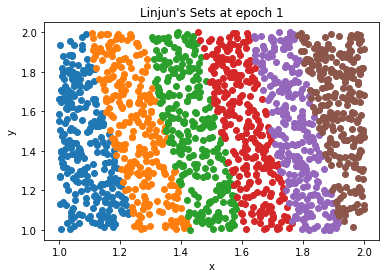

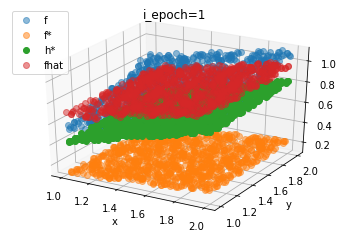

FHT MSE: 0.0056063632944284994


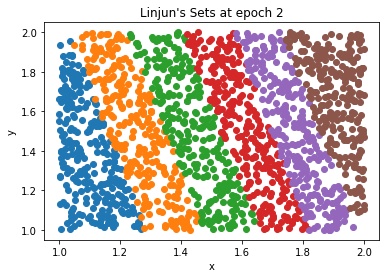

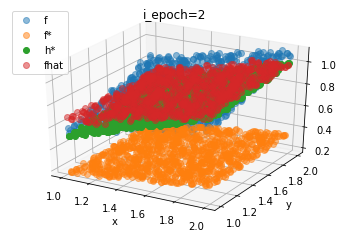

FHT MSE: 0.004544271193289489


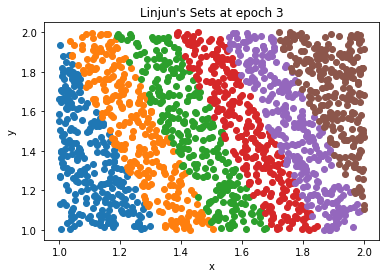

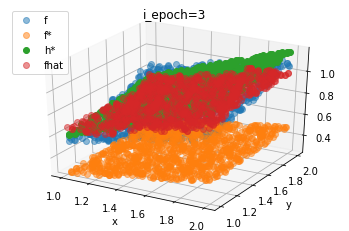

FHT MSE: 0.0037079667330179675


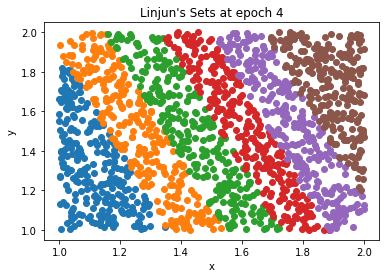

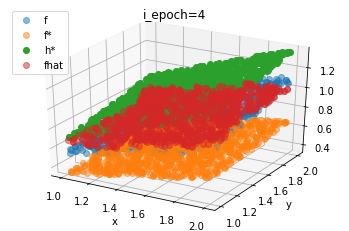

FHT MSE: 0.003166951219218074
FHT MSE: 0.0027893306119078235
FHT MSE: 0.002609153033223321
FHT MSE: 0.002493194423963854
FHT MSE: 0.002441537965452877
FHT MSE: 0.0023922015524144883
FHT MSE: 0.00236820798547347
FHT MSE: 0.0023573067945432554
FHT MSE: 0.002335223171073118
FHT MSE: 0.0023164875040750797
FHT MSE: 0.002291631661668892
FHT MSE: 0.002255004595207737
FHT MSE: 0.0022359076194774035
FHT MSE: 0.002220445058830852
FHT MSE: 0.0022170393916918336
FHT MSE: 0.0022025390354912327


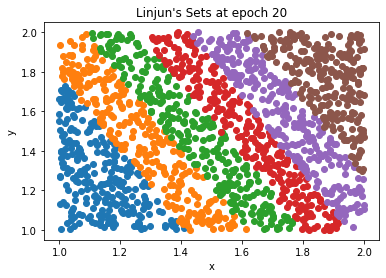

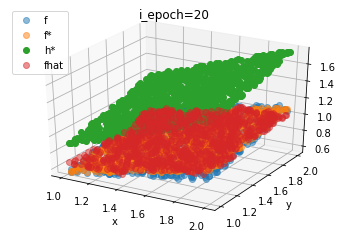

FHT MSE: 0.002177311121911036
FHT MSE: 0.0021637277161056473
FHT MSE: 0.002145797730396668
FHT MSE: 0.00214575647638908
FHT MSE: 0.00214471411394861
FHT MSE: 0.0021180491525630077
FHT MSE: 0.0021123941139789366
FHT MSE: 0.002101076162468818
FHT MSE: 0.0020842072256225894
FHT MSE: 0.0020681234131393485
FHT MSE: 0.002036507666336296
FHT MSE: 0.0020313569312624537
FHT MSE: 0.0020312992025715813
FHT MSE: 0.002012651839201863
FHT MSE: 0.0020022961604048237
FHT MSE: 0.0019900875571299188
FHT MSE: 0.0019801212247556174
FHT MSE: 0.0019677819127115513
FHT MSE: 0.0019674499982710474
FHT MSE: 0.001960754041912772
FHT MSE: 0.0019606020315899014
FHT MSE: 0.0019479009464440523
FHT MSE: 0.00194228035836238
FHT MSE: 0.001932868047994089
FHT MSE: 0.0019287497626755425
FHT MSE: 0.0019252200967503805
FHT MSE: 0.0019205700873872146
FHT MSE: 0.0019129047203447905
FHT MSE: 0.001904931819405902
FHT MSE: 0.0019048306071422722
FHT MSE: 0.0018901591986625855
FHT MSE: 0.0018834294578737487
FHT MSE: 0.00187867373

In [7]:
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.00001 * 5
reg = 0.001
n_epochs = 100
d = 2
D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
x_train = D1[0]
y_train = D1[1]
w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2)

<>:62: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:62: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:62: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-15-fc8d6e6fe4b5>:62: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(k != B - 1, 'features[sample_id] =', features[sample_id])


0.1
0
FHT MSE: 0.010861329964974829
FHT MSE: 0.010914789243730216
FHT MSE: 0.010907906321718824
FHT MSE: 0.010882322621634927
FHT MSE: 0.01088107400179554
FHT MSE: 0.010861883386575028
FHT MSE: 0.010862196367240862
FHT MSE: 0.010861787623575382
FHT MSE: 0.010853891764928522
FHT MSE: 0.010843839283307429
FHT MSE: 0.010843579504139705
FHT MSE: 0.010832349179623538
FHT MSE: 0.01082711742900031
FHT MSE: 0.010828235647598763
FHT MSE: 0.010824609917623377
FHT MSE: 0.010822461948684884
FHT MSE: 0.010826506526331265
FHT MSE: 0.01082547293199642
FHT MSE: 0.010805706691004276
FHT MSE: 0.010804917156096699
FHT MSE: 0.01081728683757822
FHT MSE: 0.010805870785500021
FHT MSE: 0.010779325156733587
FHT MSE: 0.01078296506801894
FHT MSE: 0.010783757817802508
FHT MSE: 0.010736121587988872
FHT MSE: 0.010737892934520364
FHT MSE: 0.010738480271397781
FHT MSE: 0.010742394026616999
FHT MSE: 0.010740584579457441
FHT MSE: 0.010741762869421564
FHT MSE: 0.010734895763863139
FHT MSE: 0.010733314654627011
FHT MSE: 

FHT MSE: 0.009640651146800294
FHT MSE: 0.009641076847589943
FHT MSE: 0.009640368267314046
FHT MSE: 0.009640720326628206
FHT MSE: 0.00964048382436974
FHT MSE: 0.009640738005820416
FHT MSE: 0.009640931903335745
FHT MSE: 0.009646639202658852
FHT MSE: 0.009640278417691488
FHT MSE: 0.009640423563288071
FHT MSE: 0.00964031405561545
FHT MSE: 0.009640651214367657
FHT MSE: 0.009637907233898122
FHT MSE: 0.009638210389863844
FHT MSE: 0.009638613975473
FHT MSE: 0.009642109984164045
FHT MSE: 0.00964177518366747
FHT MSE: 0.009641625957706991
FHT MSE: 0.009641627491897748
FHT MSE: 0.009641752384734272
FHT MSE: 0.00964189261072675
FHT MSE: 0.009650113782842883
FHT MSE: 0.009649863182039968
FHT MSE: 0.009650276879346442
FHT MSE: 0.00963394869516301
3
FHT MSE: 0.010434870811213462
FHT MSE: 0.010358920168026501
FHT MSE: 0.010183201003425478
FHT MSE: 0.009922298570005145
FHT MSE: 0.009905483515963794
FHT MSE: 0.009809418007039647
FHT MSE: 0.009757389071711553
FHT MSE: 0.009732663370668315
FHT MSE: 0.00972

FHT MSE: 0.0019237536917554143
FHT MSE: 0.001923608220140863
FHT MSE: 0.001918673505708555
FHT MSE: 0.0019041722906669096
FHT MSE: 0.001897133782930745
FHT MSE: 0.0018942497729449274
FHT MSE: 0.0018932530046312107
FHT MSE: 0.001892959540746341
FHT MSE: 0.0018932951593358793
FHT MSE: 0.0018900270803945479
FHT MSE: 0.0018841372332083655
FHT MSE: 0.001885321023873837
FHT MSE: 0.0018810121977399965
FHT MSE: 0.0018805584332066518
FHT MSE: 0.001875356329333476
FHT MSE: 0.0018753228273132297
FHT MSE: 0.0018717870796837385
FHT MSE: 0.0018716333993722008
FHT MSE: 0.0018729931327165824
FHT MSE: 0.0018613569922028045
FHT MSE: 0.0018585277154360333
FHT MSE: 0.0018585307080842006
FHT MSE: 0.0018586013074924804
FHT MSE: 0.0018582838564905274
FHT MSE: 0.0018560293718829957
FHT MSE: 0.0018557561699589602
FHT MSE: 0.0018556531397337771
FHT MSE: 0.0018555729853775777
FHT MSE: 0.001855480988440449
FHT MSE: 0.001855558976482528
FHT MSE: 0.001855662415510996
FHT MSE: 0.0018557065162134905
FHT MSE: 0.001853

FHT MSE: 0.000878530802620616
FHT MSE: 0.0008736061537373687
FHT MSE: 0.0008736848700849138
FHT MSE: 0.0008675145198359837
FHT MSE: 0.0008671229407876581
FHT MSE: 0.0008535158236388632
FHT MSE: 0.0008536289610611383
FHT MSE: 0.0008538010749636145
FHT MSE: 0.0008502480529992797
FHT MSE: 0.0008510005734093291
FHT MSE: 0.000848927959754984
FHT MSE: 0.0008464394466787215
FHT MSE: 0.0008404731006058188
FHT MSE: 0.0008454479182006445
FHT MSE: 0.0008455921888476644
FHT MSE: 0.0008456454279846682
FHT MSE: 0.0008457204652736868
FHT MSE: 0.0008425022155574117
FHT MSE: 0.0008417745100171944
FHT MSE: 0.0008311883154874266
FHT MSE: 0.0008304753547358843
FHT MSE: 0.0008295711924128415
FHT MSE: 0.0008260489374373033
FHT MSE: 0.0008260663007803444
FHT MSE: 0.0008241429354212557
FHT MSE: 0.0008222169593191996
FHT MSE: 0.0008231318084083894
FHT MSE: 0.0008239748948832016
FHT MSE: 0.0008240629174953353
FHT MSE: 0.000820365280243461
FHT MSE: 0.0008131024406171669
FHT MSE: 0.0008097433522761244
FHT MSE: 0.

FHT MSE: 0.0018688177053460095
FHT MSE: 0.0018687365632334234
FHT MSE: 0.0018658744177786676
FHT MSE: 0.0018660369907654605
FHT MSE: 0.001866064365701494
FHT MSE: 0.0018661196819110106
FHT MSE: 0.0018661332035921421
FHT MSE: 0.0018660038913451958
FHT MSE: 0.0018659892124879467
FHT MSE: 0.0018659568898576958
FHT MSE: 0.0018671067077424464
FHT MSE: 0.001867090375258655
FHT MSE: 0.0018670819183921135
FHT MSE: 0.00186710194529575
FHT MSE: 0.0018670589356645085
FHT MSE: 0.0018598754526672832
1
FHT MSE: 0.0034249136419849313
FHT MSE: 0.003419476186627064
FHT MSE: 0.0034185396865674357
FHT MSE: 0.003407155927025836
FHT MSE: 0.003407235382269013
FHT MSE: 0.0034022715468089754
FHT MSE: 0.0034022207219184483
FHT MSE: 0.003391282967834526
FHT MSE: 0.003389675514838374
FHT MSE: 0.0033904226420468503
FHT MSE: 0.0033801289860697073
FHT MSE: 0.003376658177294936
FHT MSE: 0.003361895521690604
FHT MSE: 0.0033594787176471665
FHT MSE: 0.0033537040145928195
FHT MSE: 0.0033536455593896905
FHT MSE: 0.003350

FHT MSE: 0.000855137960961726
FHT MSE: 0.0008551403522119766
FHT MSE: 0.0008551867633866878
FHT MSE: 0.0008551770427019116
FHT MSE: 0.0008488584303600327
FHT MSE: 0.0008492217759838794
FHT MSE: 0.0008491334905072307
FHT MSE: 0.0008490649614106413
FHT MSE: 0.0008489808796447094
FHT MSE: 0.000846575859711302
FHT MSE: 0.0008465220981686658
FHT MSE: 0.0008463391243090764
FHT MSE: 0.0008443988305493927
FHT MSE: 0.0008425621619205614
FHT MSE: 0.0008425214231458767
FHT MSE: 0.0008467518613314865
FHT MSE: 0.0008466877799342415
FHT MSE: 0.0008466312763650306
FHT MSE: 0.0008465912942473479
FHT MSE: 0.0008465611378191027
FHT MSE: 0.000846464033808439
FHT MSE: 0.0008455228738812486
FHT MSE: 0.0008461973575231726
FHT MSE: 0.0008461985860548533
FHT MSE: 0.0008462369518583064
FHT MSE: 0.0008461588040335498
FHT MSE: 0.0008460744448738199
FHT MSE: 0.0008452205888440817
FHT MSE: 0.0008452041225660229
FHT MSE: 0.0008451397115391829
FHT MSE: 0.0008451622024637473
FHT MSE: 0.0008456739760590153
FHT MSE: 0.

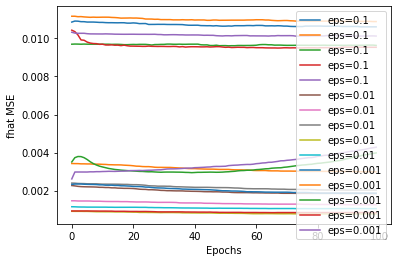

In [15]:
# Test out the code from train_multicalibration.py
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    w2_star = np.random.rand(r)
    W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid everything being mean 0
    if test:
        M = np.ones(d)
        assert(np.all(np.equal(M @ inputs, np.sum(inputs, axis=0))))
    if no_noise:
        y = (M @ inputs).reshape(1, n)
    else:
        y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star


def split_sets(w2, W1, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = W1
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    def predict(xs, j):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out[:, j]
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = predict(sets[i][0], j)
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]
            # print(features)
            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert(k != B - 1, 'features[sample_id] =', features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_set(sample, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    features = W1 @ sample

    for i in range(len(set_ranges)):
        flag = True
        for j in range(len(features)):
            if not(features[j] >= set_ranges[i][j][0] and features[j] <= set_ranges[i][j][1]):
                flag = False
                break
        if flag:
            return i
    print("The given element", sample, "could not be contained within set_ranges")
    raise ValueError


def get_sets(samples, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    def predict(xs):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out
    
    features = predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, w1, W2, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, w1, W2, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(sample, r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_num = get_set(sample, r, w2, W1, quantiles_list, set_ranges)
    weights = D2_weights[set_num]
    counts = D2_counts[set_num]
    return weights / counts


def predict(xs, w2, W1, only_top=True):
    n = len(xs)
    if only_top:
        out = np.empty((n, len(xs[0])))
        for i in range(n):
            out[i] = W1 @ xs[i]
        return out
    out = np.empty(n)
    for i in range(n):
        out[i] = w2 @ W1 @ xs[i]
    return out


def get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, 
              x_valid, y_valid, n_train, n_valid, D2):
    """Define the linear model and optimize
       d: number of dimensions of the input
       r: number of dimensions in the "second to last layer"
       eps: error added to true function in data
       lr: learning rate for gradient descent
       reg: choice of lambda for L2 regularization
       n_epochs: number of epochs to train for
    """
    mses = []

    assert(r == 1)
    w2 = np.random.rand(r)
    W1 = np.random.rand(r, d)

    for epoch in range(n_epochs):
        mse = 0
        for i in range(n_valid):
            mse += (w2 @ W1 @ x_valid[i] - y_valid[i])**2
        mse /= n_valid
        # print("Epoch", epoch, "validation MSE", mse)
        
        if epoch > 20 and epoch % 10 == 0:
            lr /= 2

        grads = np.zeros(r + d)
        for i in range(n_train):
            xi = x_train[i]
            yi = y_train[i]
            tmp = 2 * (w2 @ W1 @ xi - yi)
            grads[:r] += tmp * W1 @ xi 
            grads[r:] += tmp * w2 * xi
        w2 = w2 - lr * (grads[:r]) - reg * np.abs(w2)
        W1 = W1 - lr * (grads[r:]) - reg * np.abs(W1)
        mse = 0
        for i in range(n_valid):
            mse += (w2 @ W1 @ x_valid[i] - y_valid[i])**2
        mse /= n_valid
        # print("Epoch", epoch, "validation MSE", mse)

        # At every epoch, run Linjun's method
        sets, set_counts, set_ranges, quantiles_list = split_sets(w2, W1, (x_test, y_test), C, B, r)
        #print(set_ranges)
        D2_counts, D2_weights = compute_D2(D2, r, w2, W1, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Check the accuracy
        fhat_test = np.empty(n_test)
        for i in range(n_test):
            fhat_test[i] = fhat(x_test[i], r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges)
        mse_nn = np.square(predict(x_test, w2, W1, only_top=False) - y_test).mean()
        mse_fhat = np.square(np.subtract(fhat_test, y_test)).mean()
        print("FHT MSE:", mse_fhat)
        mses.append(mse_fhat)

        # Print the function out
        #print(W1)
        #print(w2)
        
    return w2, W1, mses





####################################################################################################


"""Make plot for varying epsilon"""

# Parameters
C = 10000
n_train, n_valid, n_test = 32000, 1000, 1000
eps = 0.001
# B = round(n_train**(1./r + 1))
r = 1
d = 5
B = 8
lr = 0.0000025 
reg = 0.01
n_epochs = 100
D1, D2_o, x_valid, y_valid_o, x_test, y_test_o, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=True)
x_train = D1[0]
y_train_o = D1[1]
mse = []

for eps in [0.1, 0.01, 0.001]:
    print(eps)
    mse2 = []
    y_valid = y_valid_o + np.random.normal(scale=eps, size=(n_valid))
    y_test = y_test_o + np.random.normal(scale=eps, size=(n_test))
    D2 = D2_o[0], D2_o[1] + np.random.normal(scale=eps, size=(n_train // 2))
    y_train = y_train_o + np.random.normal(scale=eps, size=(n_train // 2))
    for i in range(5):
        print(i)
        w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2)
        mse2.append(mses)
    mse.append(mse2)

eps = [0.1, 0.01, 0.001]
for i in range(len(eps)):
    for i_run in range(5):
        plt.plot(mse[i][i_run], label='eps=' + str(eps[i]))
plt.xlabel("Epochs")
plt.ylabel("fhat MSE")
plt.legend()
plt.show()

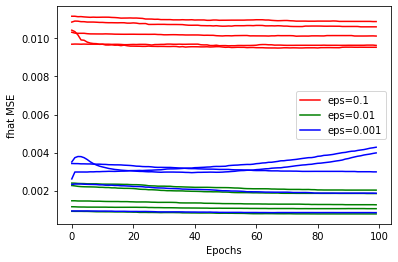

In [18]:
eps = [0.1, 0.01, 0.001]
c = ['r', 'g', 'b']
for i in range(len(eps)):
    for i_run in range(5):
        if i_run == 0:
            plt.plot(mse[i][i_run], label='eps=' + str(eps[i]), color=c[i])
        else:
            plt.plot(mse[i][i_run], color=c[i])
plt.xlabel("Epochs")
plt.ylabel("fhat MSE")
plt.legend()
plt.show()

0.1
0
FHT MSE: 0.01311714614184737
FHT MSE: 0.013153455456106225
FHT MSE: 0.013178466005636272
FHT MSE: 0.013178397184708028
FHT MSE: 0.013178397184708028
FHT MSE: 0.013178397184708028
FHT MSE: 0.013178466005636272
FHT MSE: 0.013178466005636272
FHT MSE: 0.013178466005636272
FHT MSE: 0.013178466005636272
FHT MSE: 0.013178466005636272
FHT MSE: 0.013157200046447378
FHT MSE: 0.013157450717639092
FHT MSE: 0.013153063703788213
FHT MSE: 0.013137937614691368
FHT MSE: 0.013137937614691368
FHT MSE: 0.013137937614691368
FHT MSE: 0.013137937614691368
FHT MSE: 0.013137552949319566
FHT MSE: 0.013131265920416002
FHT MSE: 0.013131265920416002
FHT MSE: 0.013128984874001194
FHT MSE: 0.013131487356339271
FHT MSE: 0.013130992358976858
FHT MSE: 0.013130992358976858
FHT MSE: 0.013127025319822096
FHT MSE: 0.013110770759539859
FHT MSE: 0.013111265756902274
FHT MSE: 0.013123013868427881
FHT MSE: 0.013128679028461654
FHT MSE: 0.013127960448429076
FHT MSE: 0.01312809635452019
FHT MSE: 0.01310789663256682
FHT MSE

FHT MSE: 0.015009725517276782
FHT MSE: 0.015009725517276782
FHT MSE: 0.015006295666949783
FHT MSE: 0.015009828153084371
FHT MSE: 0.015018847575310617
FHT MSE: 0.015018847575310617
FHT MSE: 0.015018847575310617
FHT MSE: 0.015024230336139791
FHT MSE: 0.015024230336139791
FHT MSE: 0.015024230336139791
FHT MSE: 0.015024230336139791
FHT MSE: 0.015023029037737511
FHT MSE: 0.015023029037737511
FHT MSE: 0.015023029037737511
FHT MSE: 0.015022245581605831
FHT MSE: 0.015023951983554603
FHT MSE: 0.015023951983554603
FHT MSE: 0.015023951983554603
FHT MSE: 0.015023951983554603
FHT MSE: 0.015023951983554603
FHT MSE: 0.015024171544208067
FHT MSE: 0.015024171544208067
FHT MSE: 0.015024171544208067
FHT MSE: 0.015024171544208067
FHT MSE: 0.015024304123524738
3
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE: 0.014023409546701796
FHT MSE:

FHT MSE: 0.005146407643110186
FHT MSE: 0.0051465817649971254
FHT MSE: 0.00513159639943939
FHT MSE: 0.005130156238144471
FHT MSE: 0.005129688158105397
FHT MSE: 0.005128351584947948
FHT MSE: 0.0051289022090369885
FHT MSE: 0.005129382364157798
FHT MSE: 0.005130097237634562
FHT MSE: 0.005130802056350996
FHT MSE: 0.005130802056350996
FHT MSE: 0.005131274073830701
FHT MSE: 0.005122565833048844
FHT MSE: 0.005120200781291736
FHT MSE: 0.005121137378311431
FHT MSE: 0.005119846512172094
FHT MSE: 0.005119886587980263
FHT MSE: 0.005119167057031943
FHT MSE: 0.005119167057031943
FHT MSE: 0.005119167057031943
FHT MSE: 0.005118857561921741
FHT MSE: 0.005117754067068813
FHT MSE: 0.005117754067068813
FHT MSE: 0.005117452924707431
FHT MSE: 0.005118703059638376
FHT MSE: 0.005118250117853013
FHT MSE: 0.005120937127591601
FHT MSE: 0.005120821040434861
FHT MSE: 0.005120821040434861
FHT MSE: 0.005109220110448451
FHT MSE: 0.005110150366045783
FHT MSE: 0.005109936747060585
FHT MSE: 0.005109936747060585
FHT MSE: 

FHT MSE: 0.002204752605124721
FHT MSE: 0.002204752605124721
FHT MSE: 0.002204752605124721
FHT MSE: 0.002204752605124721
FHT MSE: 0.0022055174690892745
FHT MSE: 0.0022016843420227276
FHT MSE: 0.0022016843420227276
FHT MSE: 0.0022016843420227276
FHT MSE: 0.002187728750112834
FHT MSE: 0.002177137748925965
FHT MSE: 0.002177137748925965
FHT MSE: 0.002177086570901178
FHT MSE: 0.002177086570901178
FHT MSE: 0.0021771041042738634
FHT MSE: 0.0021771041042738634
FHT MSE: 0.0021771041042738634
FHT MSE: 0.002174696457260528
FHT MSE: 0.002174696457260528
FHT MSE: 0.002174696457260528
FHT MSE: 0.002174696457260528
FHT MSE: 0.002174696457260528
FHT MSE: 0.0021746653911557754
FHT MSE: 0.0021746653911557754
FHT MSE: 0.0021746653911557754
FHT MSE: 0.002174118069182537
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.002173898453654666
FHT MSE: 0.0021635586250546256

FHT MSE: 0.005129309969562973
FHT MSE: 0.005172835932207267
FHT MSE: 0.005193981785285382
FHT MSE: 0.0052229124937636815
FHT MSE: 0.00527153967118485
1
FHT MSE: 0.003165148571257963
FHT MSE: 0.003165298621687031
FHT MSE: 0.003165298621687031
FHT MSE: 0.003165298621687031
FHT MSE: 0.003165298621687031
FHT MSE: 0.0031653515285746735
FHT MSE: 0.003165148571257963
FHT MSE: 0.003164777504052017
FHT MSE: 0.0031500563524168045
FHT MSE: 0.0031478079896670934
FHT MSE: 0.0031478079896670934
FHT MSE: 0.003145981381715947
FHT MSE: 0.003145981381715947
FHT MSE: 0.003149054853993695
FHT MSE: 0.003149354478327667
FHT MSE: 0.003149354478327667
FHT MSE: 0.0031487016574831116
FHT MSE: 0.0031487016574831116
FHT MSE: 0.0031487016574831116
FHT MSE: 0.00315274455704544
FHT MSE: 0.0031491243981522916
FHT MSE: 0.003146079617557785
FHT MSE: 0.003145347851559376
FHT MSE: 0.0031432852091970932
FHT MSE: 0.0031432852091970932
FHT MSE: 0.0031432852091970932
FHT MSE: 0.003143180080534481
FHT MSE: 0.00314297555056459

FHT MSE: 0.004541383100671343
FHT MSE: 0.004541383100671343
FHT MSE: 0.004543733716873632
FHT MSE: 0.00454301423926675
FHT MSE: 0.004545878362509164
FHT MSE: 0.004545878362509164
FHT MSE: 0.0045483946373503096
FHT MSE: 0.004552246958728303
FHT MSE: 0.004552246958728303
FHT MSE: 0.004549522630056958
FHT MSE: 0.004549522630056958
FHT MSE: 0.0045493758307056245
FHT MSE: 0.0045493758307056245
FHT MSE: 0.0045493758307056245
FHT MSE: 0.0045493758307056245
FHT MSE: 0.0045493758307056245
FHT MSE: 0.004548135917532114
FHT MSE: 0.004548135917532114
FHT MSE: 0.004548135917532114
FHT MSE: 0.004548135917532114
FHT MSE: 0.004548135917532114
FHT MSE: 0.004548283639812235
FHT MSE: 0.00454913104066166
FHT MSE: 0.00454913104066166
FHT MSE: 0.00454913104066166
FHT MSE: 0.00454913104066166
FHT MSE: 0.00454913104066166
FHT MSE: 0.0045461574421564455
FHT MSE: 0.0045461574421564455
FHT MSE: 0.0045461574421564455
FHT MSE: 0.0045461574421564455
FHT MSE: 0.0045461574421564455
FHT MSE: 0.0045461574421564455
FHT 

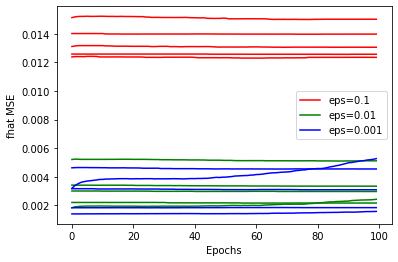

In [30]:
# Parameters
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.001
# B = round(n_train**(1./r + 1))
r = 1
d = 10
B = 8
lr = 0.000004
reg = 0.01
n_epochs = 100
D1, D2_o, x_valid, y_valid_o, x_test, y_test_o, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=True)
x_train = D1[0]
y_train_o = D1[1]
mse = []

for eps in [0.1, 0.01, 0.001]:
    print(eps)
    mse2 = []
    y_valid = y_valid_o + np.random.normal(scale=eps, size=(n_valid))
    y_test = y_test_o + np.random.normal(scale=eps, size=(n_test))
    D2 = D2_o[0], D2_o[1] + np.random.normal(scale=eps, size=(n_train // 2))
    y_train = y_train_o + np.random.normal(scale=eps, size=(n_train // 2))
    for i in range(5):
        print(i)
        w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2)
        mse2.append(mses)
    mse.append(mse2)

eps = [0.1, 0.01, 0.001]
c = ['r', 'g', 'b']
for i in range(len(eps)):
    for i_run in range(5):
        if i_run == 0:
            plt.plot(mse[i][i_run], label='eps=' + str(eps[i]), color=c[i])
        else:
            plt.plot(mse[i][i_run], color=c[i])
plt.xlabel("Epochs")
plt.ylabel("fhat MSE")
plt.legend()
plt.show()

# Begin NN trials
These should match the results above because there is no non-linearity in the model below.

In [3]:
import math
import tensorflow as tf
from tensorflow import keras

/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/n/home10/mburhanpurkar/.conda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/n/home10/mburhanpurkar/.conda/env

In [3]:
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    w2_star = np.random.rand(r)
    W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid mean 0
    if test:
        M = np.ones(d)
        assert(np.all(np.equal(M @ inputs, np.sum(inputs, axis=0))))
    y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test


def split_sets(model, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = model.predict(sets[i][0])[:, j]
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]

            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert(k != B - 1, 'features[sample_id] =', features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_sets(samples, r, model, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    features = model.predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):  ###### TODO I BELIEVE THIS IS A BUG FEATURE -> SET_RANGES[I]
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, model, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, model, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(samples, r, model, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_nums = get_sets(samples, r, model, quantiles_list, set_ranges)
    weights = D2_weights[set_nums]
    counts = D2_counts[set_nums]
    return weights / counts


def get_model(d, r, eps):
    """Define the linear model: consider adding regularization as needed"""
    inputs = keras.Input(shape=(d,))
    dense = keras.layers.Dense(units=r, 
                               use_bias=False, 
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=eps))(inputs)
    outputs = keras.layers.Dense(units=1, 
                                 use_bias=False, 
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=eps))(dense)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


class CustomCallback(keras.callbacks.Callback):
    """Define a custom callback to compute sets using model"""
    def __init__(self, D1, D2, C, B, r, x_test, y_test):
        self.D1 = D1
        self.D2 = D2
        self.C = C
        self.B = B
        self.r = r
        self.x_test = x_test
        self.y_test = y_test
        self.n_test = len(x_test)
        self.nn_mses = []
        self.fhat_mses = []

    def on_epoch_end(self, epoch, logs=None):
        # Call split sets
        sets, set_counts, set_ranges, quantiles_list = split_sets(self.model, self.D1, self.C, self.B, self.r)

        # Call compute D2
        D2_counts, D2_weights = compute_D2(self.D2, self.r, self.model, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Compute test accuracy
        fhat_test = np.empty(self.n_test)
        fhat_test = fhat(self.x_test, self.r, self.model, quantiles_list, D2_weights, D2_counts, set_ranges)
        fstar_test = model.predict(self.x_test)
        mse_nn = np.square(np.subtract(fstar_test, self.y_test)).mean()
        mse_fhat = np.square(np.subtract(fhat_test, self.y_test)).mean()
        print("Epoch", epoch, "fhat MSE:", mse_fhat)
        self.nn_mses.append(mse_nn)
        self.fhat_mses.append(mse_fhat)

        # Add a visualization
        if (epoch < 5 or epoch == 20):
            %matplotlib inline 
            fig = plt.figure()
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()

            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            plt.plot(x_test[:, 0], x_test[:, 1], y_test, 'o', label='f', alpha=0.5)
            plt.plot(x_test[:, 0], x_test[:, 1], fstar_test.flatten(), 'o', label='f*', alpha=0.5)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()

        # Save to some outfile
        if epoch % 10 == 0:
            np.savetxt('nn_mse.txt', np.array(self.nn_mses))
            np.savetxt('fhat_mse.txt', np.array(self.fhat_mses))

        
def train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test):
    """Train the model (with Adam to avoid gradient problems)"""
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        return lr * math.exp(-0.1)    
    
    n_epochs = 100
    batch_size = 100
    lr = 0.1
    cb1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                          patience=10, verbose=0, baseline=None)
    cb2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
    cb3 = CustomCallback(D1, D2, C, B, r, x_test, y_test)

    model.compile(optimizer=keras.optimizers.Adam(lr=lr, clipnorm=1),
                  loss=tf.keras.losses.MSE)
    
    print(np.shape(D1[0]))

    history = model.fit(D1[0], D1[1], batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        epochs=n_epochs, callbacks=[cb1, cb2, cb3])

    # Compute the test MSE
    out = model.evaluate(x=x_test, y=y_test)
    return out

<>:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-3-cde87c137018>:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(k != B - 1, 'features[sample_id] =', features[sample_id])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
(1600, 2)
Train on 1600 samples, validate on 1000 samples
Epoch 1/100
 100/1600 [>.............................] - ETA: 1s - loss: 8.9381Epoch 0 fhat MSE: 0.017122615412980997


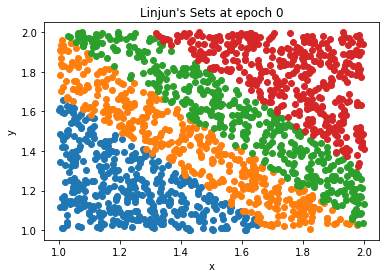

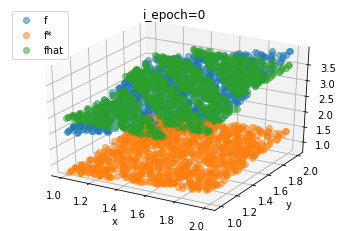

1600/1600 [==============================] - 1s 343us/step - loss: 8.4652 - val_loss: 3.7553
Epoch 2/100
 100/1600 [>.............................] - ETA: 0s - loss: 3.6071Epoch 1 fhat MSE: 0.01708520317715482


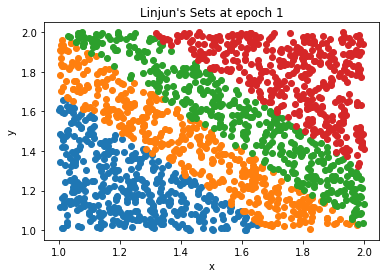

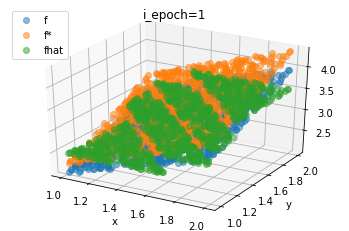

1600/1600 [==============================] - 0s 266us/step - loss: 1.6578 - val_loss: 0.1022
Epoch 3/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.1076Epoch 2 fhat MSE: 0.017095103806507566


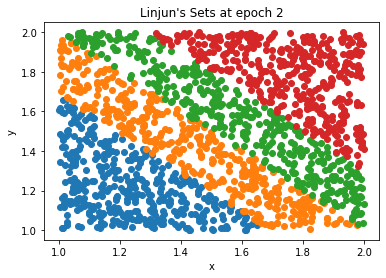

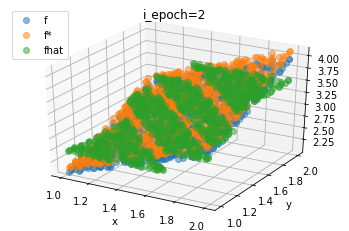

1600/1600 [==============================] - 0s 265us/step - loss: 0.1728 - val_loss: 0.0134
Epoch 4/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0134Epoch 3 fhat MSE: 0.01708144842506736


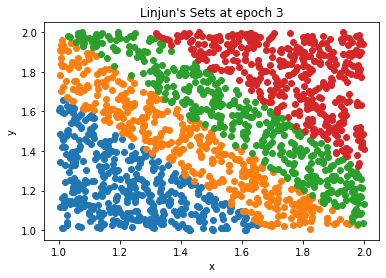

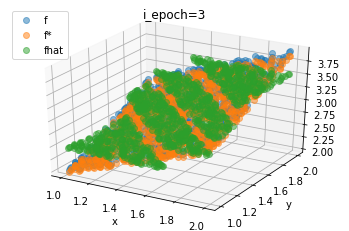

1600/1600 [==============================] - 0s 269us/step - loss: 0.0254 - val_loss: 0.0044
Epoch 5/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0048Epoch 4 fhat MSE: 0.017083029559943733


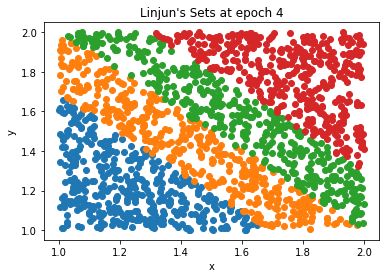

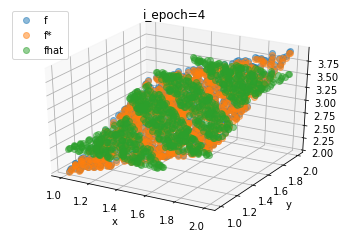

1600/1600 [==============================] - 0s 272us/step - loss: 0.0046 - val_loss: 7.9505e-04
Epoch 6/100
1600/1600 [==============================] - 0s 92us/step - loss: 0.0011 - val_loss: 8.2155e-04
Epoch 7/100
1600/1600 [==============================] - 0s 133us/step - loss: 3.0792e-04 - val_loss: 1.2695e-04
Epoch 8/100
1600/1600 [==============================] - 0s 90us/step - loss: 1.5463e-04 - val_loss: 1.1597e-04
Epoch 9/100
1600/1600 [==============================] - 0s 90us/step - loss: 1.2696e-04 - val_loss: 1.1474e-04
Epoch 10/100
1600/1600 [==============================] - 0s 92us/step - loss: 1.1963e-04 - val_loss: 1.0754e-04
Epoch 11/100
1600/1600 [==============================] - 0s 129us/step - loss: 1.1602e-04 - val_loss: 1.0310e-04
Epoch 12/100
1600/1600 [==============================] - 0s 113us/step - loss: 1.0932e-04 - val_loss: 1.0348e-04
Epoch 13/100
1600/1600 [==============================] - 0s 104us/step - loss: 1.0866e-04 - val_loss: 1.1080e-04
Epo

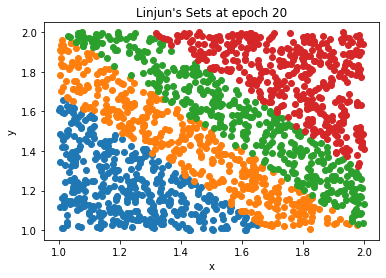

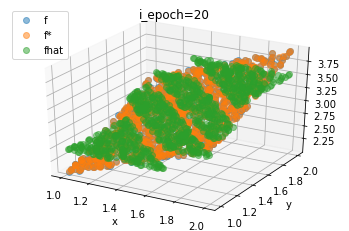

1000/1000 [==============================] - 0s 13us/step


In [5]:
# Parameters
C = 100
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01
r = 1 # it looks like there is a bug for r != 1 because that results in set errors unless D2 = D1...
d = 2
B = 4
D1, D2, x_valid, y_valid, x_test, y_test = get_data(r, d, C, n_train, n_valid, n_test, eps, test=True)
#D2 = D1
model = get_model(d, r, eps)
mse = train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test)
sets, set_counts, set_ranges, quantiles_list = split_sets(model, (x_test, y_test), C, B, r)
D2_counts, D2_weights = compute_D2(D2, r, model, quantiles_list, set_ranges)

# Add a non-linearity...

In [12]:
def get_data(r, d, C, n_train, n_valid, n_test, eps):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    true_model = get_model(d, r, eps)
    inputs = np.random.rand(n, d) + 1 # add 1 to avoid mean 0
    y = (true_model.predict(inputs)).reshape(n)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test


def split_sets(model, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = model.predict(sets[i][0])[:, j]
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]

            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert(k != B - 1, 'features[sample_id] =', features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_sets(samples, r, model, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    features = model.predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):  ###### TODO I BELIEVE THIS IS A BUG FEATURE -> SET_RANGES[I]
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, model, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, model, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(samples, r, model, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_nums = get_sets(samples, r, model, quantiles_list, set_ranges)
    weights = D2_weights[set_nums]
    counts = D2_counts[set_nums]
    return weights / counts


def get_model(d, r, eps):
    """Define the linear model: consider adding regularization as needed"""
    inputs = keras.Input(shape=(d,))
    dense = keras.layers.Dense(units=r, 
                               use_bias=False, 
                               activation='relu',
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1))(inputs)
    outputs = keras.layers.Dense(units=1, 
                                 use_bias=False, 
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1))(dense)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


class CustomCallback(keras.callbacks.Callback):
    """Define a custom callback to compute sets using model"""
    def __init__(self, D1, D2, C, B, r, x_test, y_test):
        self.D1 = D1
        self.D2 = D2
        self.C = C
        self.B = B
        self.r = r
        self.x_test = x_test
        self.y_test = y_test
        self.n_test = len(x_test)
        self.nn_mses = []
        self.fhat_mses = []

    def on_epoch_end(self, epoch, logs=None):
        # Call split sets
        sets, set_counts, set_ranges, quantiles_list = split_sets(self.model, self.D1, self.C, self.B, self.r)

        # Call compute D2
        D2_counts, D2_weights = compute_D2(self.D2, self.r, self.model, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Compute test accuracy
        fhat_test = np.empty(self.n_test)
        fhat_test = fhat(self.x_test, self.r, self.model, quantiles_list, D2_weights, D2_counts, set_ranges)
        fstar_test = model.predict(self.x_test)
        mse_nn = np.square(np.subtract(fstar_test, self.y_test)).mean()
        mse_fhat = np.square(np.subtract(fhat_test, self.y_test)).mean()
        print("Epoch", epoch, "fhat MSE:", mse_fhat)
        self.nn_mses.append(mse_nn)
        self.fhat_mses.append(mse_fhat)

        # Add a visualization
        if (epoch < 5 or epoch == 20):
            %matplotlib inline 
            fig = plt.figure()
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()

            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            plt.plot(x_test[:, 0], x_test[:, 1], y_test, 'o', label='f', alpha=0.5)
            plt.plot(x_test[:, 0], x_test[:, 1], fstar_test.flatten(), 'o', label='f*', alpha=0.5)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()

        # Save to some outfile
        if epoch % 10 == 0:
            np.savetxt('nn_mse.txt', np.array(self.nn_mses))
            np.savetxt('fhat_mse.txt', np.array(self.fhat_mses))

        
def train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test):
    """Train the model (with Adam to avoid gradient problems)"""
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        return lr * math.exp(-0.1)    
    
    n_epochs = 100
    batch_size = 100
    lr = 0.1
    cb1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                          patience=10, verbose=0, baseline=None)
    cb2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
    cb3 = CustomCallback(D1, D2, C, B, r, x_test, y_test)

    model.compile(optimizer=keras.optimizers.Adam(lr=lr, clipnorm=1),
                  loss=tf.keras.losses.MSE)
    
    print(np.shape(D1[0]))

    history = model.fit(D1[0], D1[1], batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        epochs=n_epochs, callbacks=[cb1, cb2, cb3])

    # Compute the test MSE
    out = model.evaluate(x=x_test, y=y_test)
    return out

<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-12-51b9e82d3800>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(k != B - 1, 'features[sample_id] =', features[sample_id])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 1         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_39 (D

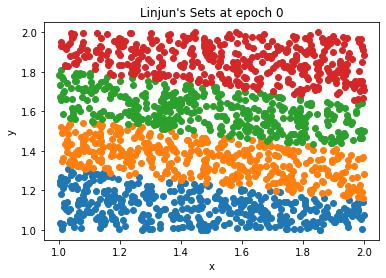

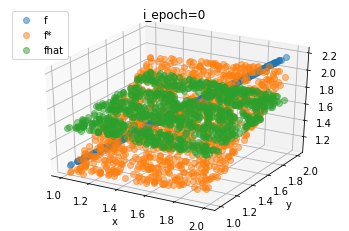

1600/1600 [==============================] - 1s 816us/step - loss: 0.9530 - val_loss: 0.1681
Epoch 2/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.2040Epoch 1 fhat MSE: 0.09291435858356437


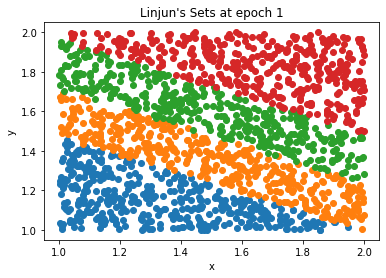

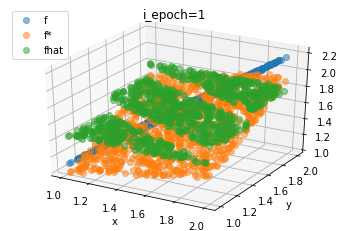

1600/1600 [==============================] - 1s 577us/step - loss: 0.1915 - val_loss: 0.1296
Epoch 3/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.1197Epoch 2 fhat MSE: 0.06261694070415742


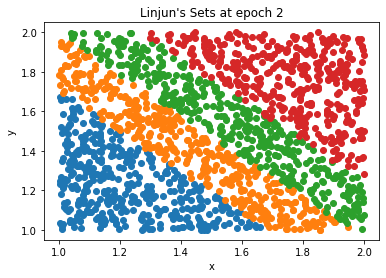

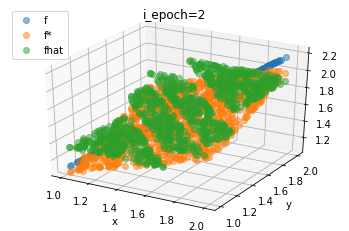

1600/1600 [==============================] - 1s 579us/step - loss: 0.0977 - val_loss: 0.0688
Epoch 4/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0789Epoch 3 fhat MSE: 0.029755729301878003


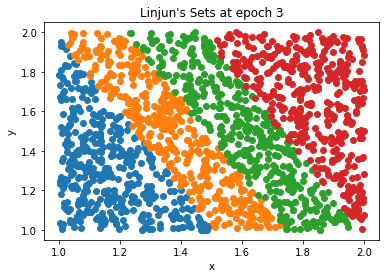

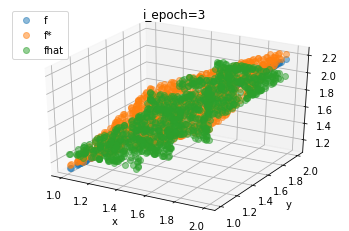

1600/1600 [==============================] - 1s 586us/step - loss: 0.0485 - val_loss: 0.0332
Epoch 5/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0325Epoch 4 fhat MSE: 0.01487392361148621


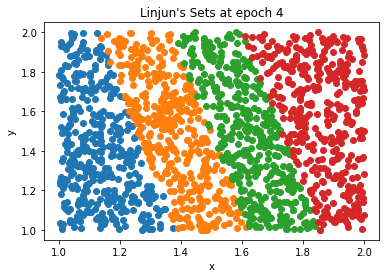

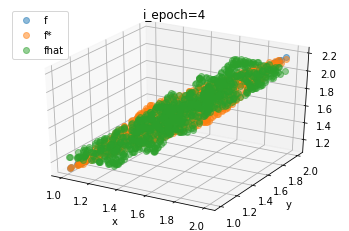

1600/1600 [==============================] - 1s 589us/step - loss: 0.0233 - val_loss: 0.0116
Epoch 6/100
1600/1600 [==============================] - 1s 427us/step - loss: 0.0076 - val_loss: 0.0030
Epoch 7/100
1600/1600 [==============================] - 1s 429us/step - loss: 0.0015 - val_loss: 4.2218e-04
Epoch 8/100
1600/1600 [==============================] - 1s 443us/step - loss: 1.9875e-04 - val_loss: 5.2066e-06
Epoch 9/100
1600/1600 [==============================] - 1s 436us/step - loss: 2.6557e-05 - val_loss: 1.4493e-05
Epoch 10/100
1600/1600 [==============================] - 1s 441us/step - loss: 1.1778e-05 - val_loss: 6.1800e-06
Epoch 11/100
1600/1600 [==============================] - 1s 463us/step - loss: 2.4089e-06 - val_loss: 7.6595e-07
Epoch 12/100
1600/1600 [==============================] - 1s 445us/step - loss: 2.0661e-07 - val_loss: 7.7108e-08
Epoch 13/100
1600/1600 [==============================] - 1s 447us/step - loss: 5.6748e-08 - val_loss: 2.7707e-08
Epoch 14/10

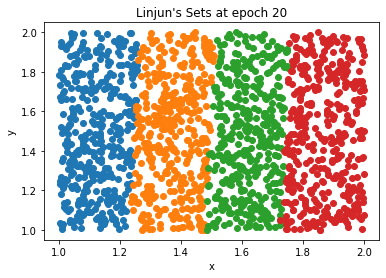

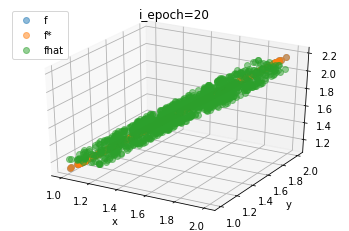

1600/1600 [==============================] - 1s 720us/step - loss: 1.7265e-13 - val_loss: 7.5204e-14
Epoch 22/100
1600/1600 [==============================] - 1s 445us/step - loss: 5.7154e-14 - val_loss: 3.8270e-14
Epoch 23/100
1600/1600 [==============================] - 1s 437us/step - loss: 4.0972e-14 - val_loss: 4.1410e-14
Epoch 24/100
1600/1600 [==============================] - 1s 438us/step - loss: 3.9941e-14 - val_loss: 3.9961e-14
Epoch 25/100
1600/1600 [==============================] - 1s 439us/step - loss: 4.0181e-14 - val_loss: 4.0330e-14
Epoch 26/100
1600/1600 [==============================] - 1s 439us/step - loss: 4.0083e-14 - val_loss: 4.0146e-14
Epoch 27/100
1600/1600 [==============================] - 1s 441us/step - loss: 3.9879e-14 - val_loss: 4.0146e-14
Epoch 28/100
1600/1600 [==============================] - 1s 441us/step - loss: 3.9879e-14 - val_loss: 4.0146e-14
Epoch 29/100
1600/1600 [==============================] - 1s 441us/step - loss: 3.9861e-14 - val_loss

In [16]:
C = 10000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01
r = 1 # it looks like there is a bug for r != 1 because that results in set errors unless D2 = D1...
d = 2
B = 4
D1, D2, x_valid, y_valid, x_test, y_test = get_data(r, d, C, n_train, n_valid, n_test, eps)
#D2 = D1
model = get_model(d, r, eps)
mse = train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test)
sets, set_counts, set_ranges, quantiles_list = split_sets(model, (x_test, y_test), C, B, r)
D2_counts, D2_weights = compute_D2(D2, r, model, quantiles_list, set_ranges)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 1         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_47 (D

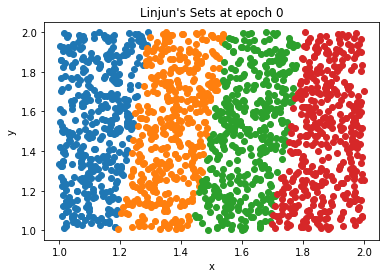

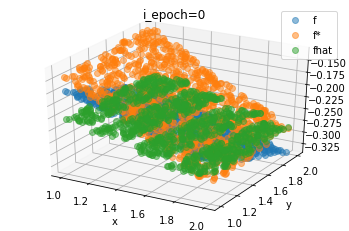

1600/1600 [==============================] - 2s 997us/step - loss: 0.0062 - val_loss: 0.0032
Epoch 2/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0026Epoch 1 fhat MSE: 0.00048118302849253715


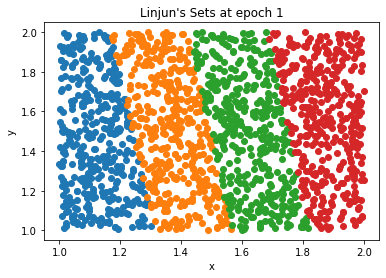

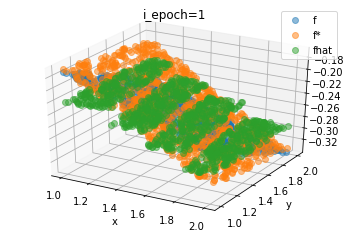

1600/1600 [==============================] - 1s 680us/step - loss: 0.0017 - val_loss: 6.6398e-04
Epoch 3/100
 100/1600 [>.............................] - ETA: 0s - loss: 5.7429e-04Epoch 2 fhat MSE: 0.000327924335472083


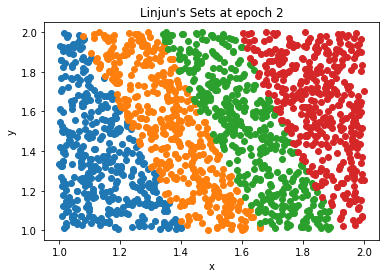

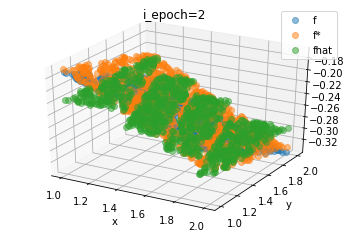

1600/1600 [==============================] - 1s 684us/step - loss: 4.9547e-04 - val_loss: 2.9719e-04
Epoch 4/100
 100/1600 [>.............................] - ETA: 0s - loss: 2.3719e-04Epoch 3 fhat MSE: 0.00022502520427190298


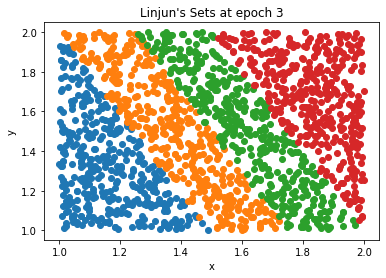

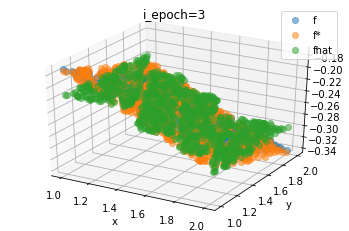

1600/1600 [==============================] - 1s 691us/step - loss: 1.6945e-04 - val_loss: 1.1787e-04
Epoch 5/100
 100/1600 [>.............................] - ETA: 0s - loss: 1.0723e-04Epoch 4 fhat MSE: 0.00017727192583364684


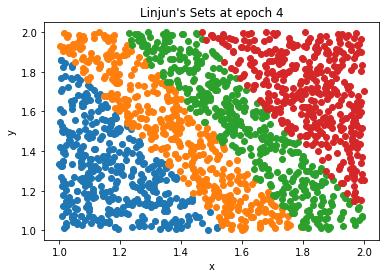

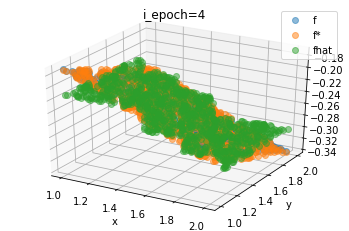

1600/1600 [==============================] - 1s 692us/step - loss: 8.0305e-05 - val_loss: 5.1686e-05
Epoch 6/100
1600/1600 [==============================] - 1s 519us/step - loss: 3.8978e-05 - val_loss: 2.7626e-05
Epoch 7/100
1600/1600 [==============================] - 1s 524us/step - loss: 1.6815e-05 - val_loss: 1.1555e-05
Epoch 8/100
1600/1600 [==============================] - 1s 521us/step - loss: 8.0151e-06 - val_loss: 5.2644e-06
Epoch 9/100
1600/1600 [==============================] - 1s 522us/step - loss: 3.6248e-06 - val_loss: 3.2462e-06
Epoch 10/100
1600/1600 [==============================] - 1s 529us/step - loss: 2.0804e-06 - val_loss: 1.0179e-06
Epoch 11/100
1600/1600 [==============================] - 1s 548us/step - loss: 7.2419e-07 - val_loss: 3.8710e-07
Epoch 12/100
1600/1600 [==============================] - 1s 539us/step - loss: 2.4520e-07 - val_loss: 1.7728e-07
Epoch 13/100
1600/1600 [==============================] - 1s 530us/step - loss: 1.1099e-07 - val_loss: 7.

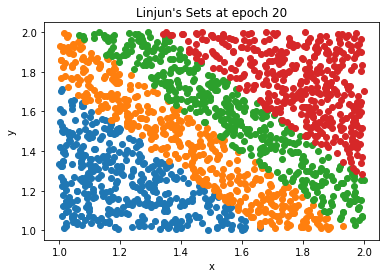

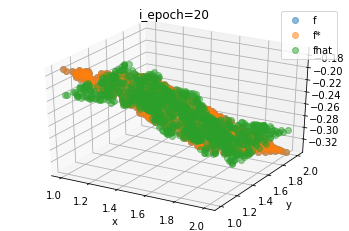

1600/1600 [==============================] - 1s 797us/step - loss: 1.2986e-09 - val_loss: 1.0590e-09
Epoch 22/100
1600/1600 [==============================] - 1s 519us/step - loss: 8.4355e-10 - val_loss: 7.3938e-10
Epoch 23/100
1600/1600 [==============================] - 1s 515us/step - loss: 6.0792e-10 - val_loss: 5.4307e-10
Epoch 24/100
 100/1600 [>.............................] - ETA: 0s - loss: 6.4916e-10

In [ ]:
C = 10000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01
r = 1 # it looks like there is a bug for r != 1 because that results in set errors unless D2 = D1...
d = 2
B = 4
D1, D2, x_valid, y_valid, x_test, y_test = get_data(r, d, C, n_train, n_valid, n_test, eps)
#D2 = D1
model = get_model(d, r, eps)
mse = train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test)
sets, set_counts, set_ranges, quantiles_list = split_sets(model, (x_test, y_test), C, B, r)
D2_counts, D2_weights = compute_D2(D2, r, model, quantiles_list, set_ranges)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 1         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_59 (D

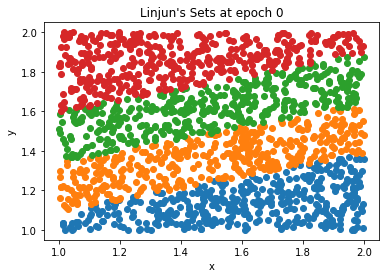

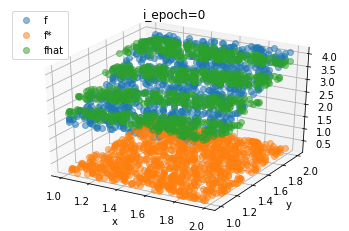

1600/1600 [==============================] - 2s 1ms/step - loss: 16.5196 - val_loss: 8.7653
Epoch 2/100
 100/1600 [>.............................] - ETA: 0s - loss: 8.6140Epoch 1 fhat MSE: 0.05486771488965048


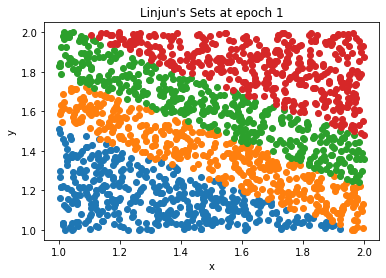

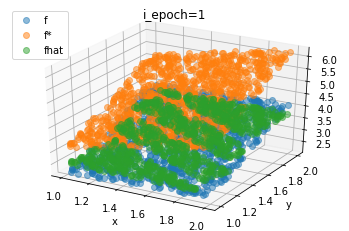

1600/1600 [==============================] - 1s 772us/step - loss: 3.3629 - val_loss: 2.6249
Epoch 3/100
 100/1600 [>.............................] - ETA: 0s - loss: 2.6029Epoch 2 fhat MSE: 0.032157202512845214


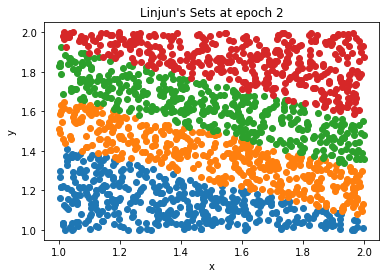

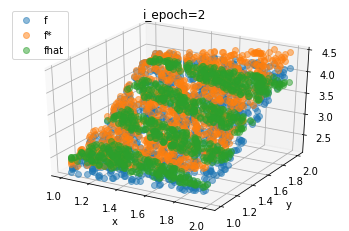

1600/1600 [==============================] - 1s 789us/step - loss: 0.6885 - val_loss: 0.0856
Epoch 4/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0861Epoch 3 fhat MSE: 0.021156595193871523


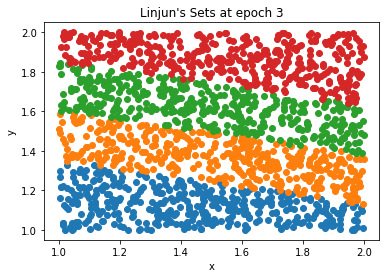

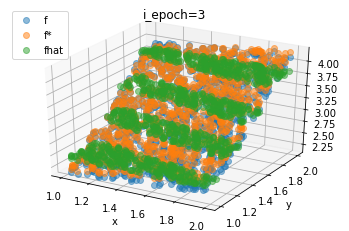

1600/1600 [==============================] - 1s 758us/step - loss: 0.0835 - val_loss: 0.0076
Epoch 5/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0085Epoch 4 fhat MSE: 0.019064351106444874


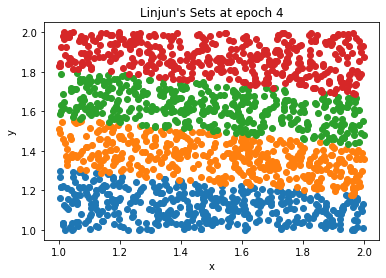

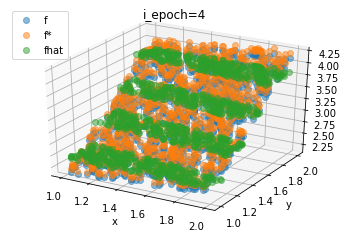

1600/1600 [==============================] - 1s 794us/step - loss: 0.0101 - val_loss: 0.0067
Epoch 6/100
1600/1600 [==============================] - 1s 621us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/100
1600/1600 [==============================] - 1s 595us/step - loss: 5.3201e-04 - val_loss: 2.2034e-04
Epoch 8/100
1600/1600 [==============================] - 1s 634us/step - loss: 1.0098e-04 - val_loss: 6.2038e-06
Epoch 9/100
1600/1600 [==============================] - 1s 570us/step - loss: 2.1278e-05 - val_loss: 1.4618e-05
Epoch 10/100
1600/1600 [==============================] - 1s 634us/step - loss: 4.7656e-06 - val_loss: 2.2941e-07
Epoch 11/100
1600/1600 [==============================] - 1s 539us/step - loss: 7.4337e-07 - val_loss: 4.7577e-07
Epoch 12/100
1600/1600 [==============================] - 1s 488us/step - loss: 1.3520e-07 - val_loss: 4.4740e-08
Epoch 13/100
1600/1600 [==============================] - 1s 625us/step - loss: 2.9942e-08 - val_loss: 4.7323e-10
Epoch 1

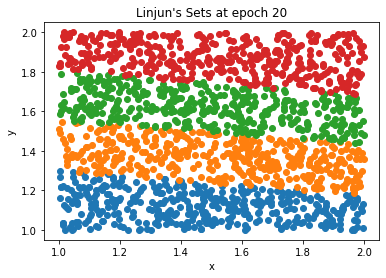

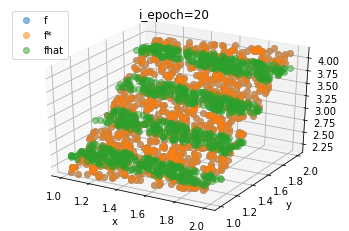

1600/1600 [==============================] - 1s 863us/step - loss: 9.7186e-11 - val_loss: 1.0096e-10
Epoch 22/100
1600/1600 [==============================] - 1s 556us/step - loss: 9.5583e-11 - val_loss: 1.0473e-10
Epoch 23/100
1600/1600 [==============================] - 1s 614us/step - loss: 9.8855e-11 - val_loss: 1.1330e-10
Epoch 24/100
1600/1600 [==============================] - 1s 621us/step - loss: 1.0253e-10 - val_loss: 1.0557e-10
Epoch 25/100
1600/1600 [==============================] - 1s 637us/step - loss: 1.0209e-10 - val_loss: 1.0157e-10
Epoch 26/100
1600/1600 [==============================] - 1s 526us/step - loss: 9.7342e-11 - val_loss: 1.0189e-10
Epoch 27/100
1600/1600 [==============================] - 1s 537us/step - loss: 9.7459e-11 - val_loss: 1.0234e-10
Epoch 28/100
1000/1000 [==============================] - 0s 10us/step


In [29]:
# This is so beautiful I Just want to leave it here--this is  with NO NONLINEARITY
C = 100
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.00001
r = 1 # it looks like there is a bug for r != 1 because that results in set errors unless D2 = D1...
d = 2
B = 4
D1, D2, x_valid, y_valid, x_test, y_test = get_data(r, d, C, n_train, n_valid, n_test, eps)
#D2 = D1
model = get_model(d, r, eps)
mse = train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test)
sets, set_counts, set_ranges, quantiles_list = split_sets(model, (x_test, y_test), C, B, r)
D2_counts, D2_weights = compute_D2(D2, r, model, quantiles_list, set_ranges)

# 9/6/21 Non-Linearity Tests (last slide of linear model debugging section)

In [32]:
def get_data(r, d, C, n_train, n_valid, n_test, eps):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    true_model = get_model(d, r, eps)
    inputs = np.random.rand(n, d) + 1 # add 1 to avoid mean 0
    y = (true_model.predict(inputs)).reshape(n)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test


def split_sets(model, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = model.predict(sets[i][0])[:, j]
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]

            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert(k != B - 1, 'features[sample_id] =', features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_sets(samples, r, model, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    new_model = keras.Model(inputs=model.input, outputs=model.get_layer(model.layers[1].name).output)
    features = new_model(samples).numpy()
    print("Model into get_sets")
    for layer in new_model.layers: print(layer.get_config(), layer.get_weights())
    print("\nFeatures")
    for i in range(len(features)):
        print(samples[i], features[i])
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):  ###### TODO I BELIEVE THIS IS A BUG FEATURE -> SET_RANGES[I]
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, model, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, model, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(samples, r, model, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_nums = get_sets(samples, r, model, quantiles_list, set_ranges)
    weights = D2_weights[set_nums]
    counts = D2_counts[set_nums]
    return weights / counts


def get_model(d, r, eps):
    """Define the linear model: consider adding regularization as needed"""
    inputs = keras.Input(shape=(d,))
    dense = keras.layers.Dense(units=r, 
                               use_bias=False, 
                               activation='relu',
                               kernel_initializer = tf.keras.initializers.RandomUniform())(inputs)
    outputs = keras.layers.Dense(units=1, 
                                 use_bias=False, 
                                 kernel_initializer = tf.keras.initializers.RandomUniform())(dense)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


class CustomCallback(keras.callbacks.Callback):
    """Define a custom callback to compute sets using model"""
    def __init__(self, D1, D2, C, B, r, x_test, y_test):
        self.D1 = D1
        self.D2 = D2
        self.C = C
        self.B = B
        self.r = r
        self.x_test = x_test
        self.y_test = y_test
        self.n_test = len(x_test)
        self.nn_mses = []
        self.fhat_mses = []

    def on_epoch_end(self, epoch, logs=None):
        for layer in self.model.layers: print(layer.get_config(), layer.get_weights())
    
        # Call split sets
        sets, set_counts, set_ranges, quantiles_list = split_sets(self.model, self.D1, self.C, self.B, self.r)

        # Call compute D2
        D2_counts, D2_weights = compute_D2(self.D2, self.r, self.model, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                print("All set_ranges below:")
                print(set_ranges)
                raise ValueError

        # Compute test accuracy
        fhat_test = np.empty(self.n_test)
        fhat_test = fhat(self.x_test, self.r, self.model, quantiles_list, D2_weights, D2_counts, set_ranges)
        fstar_test = self.model(self.x_test).numpy()
        mse_nn = np.square(np.subtract(fstar_test, self.y_test)).mean()
        mse_fhat = np.square(np.subtract(fhat_test, self.y_test)).mean()
        print("Epoch", epoch, "fhat MSE:", mse_fhat)
        self.nn_mses.append(mse_nn)
        self.fhat_mses.append(mse_fhat)

        # Add a visualization
        if (epoch < 5 or epoch == 20):
            %matplotlib inline 
            fig = plt.figure()
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()

            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            plt.plot(x_test[:, 0], x_test[:, 1], y_test, 'o', label='f', alpha=0.5)
            plt.plot(x_test[:, 0], x_test[:, 1], fstar_test.flatten(), 'o', label='f*', alpha=0.5)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()

        # Save to some outfile
        if epoch % 10 == 0:
            np.savetxt('nn_mse.txt', np.array(self.nn_mses))
            np.savetxt('fhat_mse.txt', np.array(self.fhat_mses))

        
def train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test):
    """Train the model (with Adam to avoid gradient problems)"""
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        return lr * math.exp(-0.1)    
    
    n_epochs = 100
    batch_size = 100
    lr = 0.1
    cb1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                          patience=10, verbose=0, baseline=None)
    cb2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
    cb3 = CustomCallback(D1, D2, C, B, r, x_test, y_test)

    model.compile(optimizer=keras.optimizers.Adam(lr=lr, clipnorm=1),
                  loss=tf.keras.losses.MSE)
    
    print(np.shape(D1[0]))

    history = model.fit(D1[0], D1[1], batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        epochs=n_epochs, callbacks=[cb1, cb2, cb3])

    # Compute the test MSE
    out = model.evaluate(x=x_test, y=y_test)
    return out

<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-32-10993563f223>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(k != B - 1, 'features[sample_id] =', features[sample_id])


In [33]:
C = 10000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01
r = 1 # it looks like there is a bug for r != 1 because that results in set errors unless D2 = D1...
d = 2
B = 4
D1, D2, x_valid, y_valid, x_test, y_test = get_data(r, d, C, n_train, n_valid, n_test, eps)
#D2 = D1
model = get_model(d, r, eps)
mse = train_model(model, D1, D2, x_valid, y_valid, C, B, r, x_test, y_test)
sets, set_counts, set_ranges, quantiles_list = split_sets(model, (x_test, y_test), C, B, r)
D2_counts, D2_weights = compute_D2(D2, r, model, quantiles_list, set_ranges)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 1         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_55 (D

AttributeError: 'Tensor' object has no attribute 'numpy'